In [ ]:
!pip install sentence-transformers

In [112]:
from google.colab import drive
import pandas as pd
import numpy as np
# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to the file on your Google Drive
file_path = '/content/drive/MyDrive/ClinNotes.csv'

# Read the file using pandas


# Access the data from the file
# ... Your code here ...

data = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
data['category'].value_counts()

Cardiovascular / Pulmonary    371
Gastroenterology              224
Neurology                     223
Name: category, dtype: int64

In [ ]:
file_path = '/content/drive/MyDrive/MedicalConcepts.csv'
medical_terms = pd.read_csv(file_path)
medical_terms['Term1'] = medical_terms['Term1'].apply(lambda x: x.lower())
medical_terms['Term2'] = medical_terms['Term2'].apply(lambda x: x.lower())
medical_terms.drop_duplicates(keep='first', inplace=True)
medical_terms.shape

(558, 2)

In [114]:
def load_embedding(file_name = "bert_embedding.csv"):
    emb = pd.read_csv(file_name)
    emb.drop(['Unnamed: 0'], axis=1, inplace=True)
    return emb

In [115]:
from sklearn.metrics.pairwise import cosine_similarity
def calculate_similarity(row):
    similarity = cosine_similarity([row['term1']], [row['term2']])[0][0]
    return similarity

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plotEmbeddings(embeddings, categories, model):
    df = pd.DataFrame(embeddings)
    df["Data_Point"] = categories

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_tsne = tsne.fit_transform(df.drop(["Data_Point"], axis=1))

    df["TSNE_X"] = embeddings_tsne[:, 0]
    df["TSNE_Y"] = embeddings_tsne[:, 1]

    plt.figure(figsize=(12, 8))

    colors = {"Neurology": "red", "Gastroenterology": "green", "Cardiovascular / Pulmonary": "blue"}

    sns.scatterplot(x="TSNE_X", y="TSNE_Y", hue="Data_Point", data=df, palette=colors)

    plt.title(f"Embeddings Visualization with {model} Embedding size as: {len(embeddings[0])}")
    plt.xlabel("TSNE_X")
    plt.ylabel("TSNE_Y")

    plt.show()

In [116]:
from sklearn.cluster import KMeans
def plotKmeansClusteredEmbeddings(embeddings, model, n_clusters=3):

    kmeans = KMeans(n_clusters)
    cluster_labels = kmeans.fit_predict(embeddings)


    tsne = TSNE(n_components=2)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(13, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title(f'K-means Clustering of {model} Embeddings')
    plt.show()

    clustering_res = pd.DataFrame({'category':list(data['category']), 'label':list(kmeans.labels_)})
    word_cloud_df = pd.DataFrame({'notes':list(data['notes']), 'label':list(kmeans.labels_)})
    word_cloud_df = word_cloud_df.groupby('label')['notes'].apply(lambda x: ', '.join(x)).reset_index()

    print(f"K-Means clustering summary on {model}")
    for i in range(n_clusters):
        print(f"***********Data points in cluster: {i}  :**************")
        print(clustering_res[clustering_res['label']==i]['category'].value_counts())

        # print(f"\n*****Freuent words in cluster {i} *******\n")
        # makeWordCloud(str(word_cloud_df[word_cloud_df['label'] == i].values))


## USING UNIVERSAL SENTENSE ENCODER**

In [ ]:

import tensorflow as tf
import tensorflow_hub as hub


# Specify the URL of the pretrained model trained on health data
model_url = "https://tfhub.dev/google/universal-sentence-encoder-large/4"

# Load the pretrained model
embed = hub.load(model_url)



In [ ]:
# Obtain the sentence embeddings

def get_embedding(text):
  embeddings = embed([text])
  return embeddings

In [ ]:
USE_emb = data['notes'].apply(get_embedding)

In [ ]:
USE_embeddings = [USE_emb[i]['outputs'].numpy()[0] for i in  range(USE_emb.size)]
pd.DataFrame(USE_embeddings).to_csv("/content/drive/MyDrive/use_embeddings.csv")

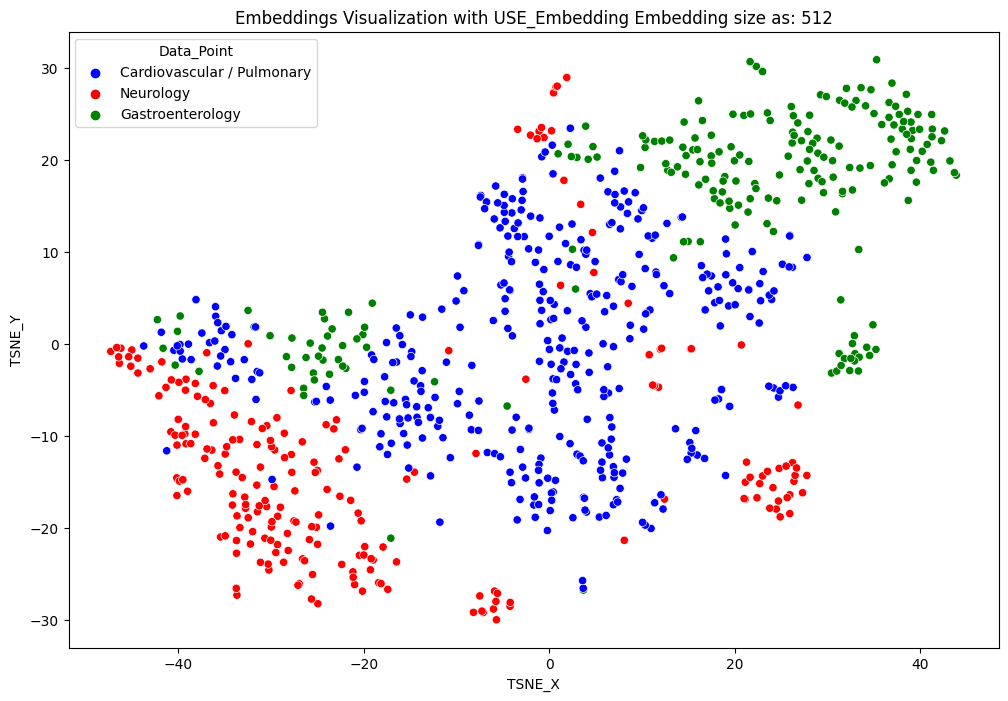

In [ ]:
USE_embeddings2 = np.array(load_embedding(file_name = "/content/drive/MyDrive/use_embeddings.csv"))
plotEmbeddings(USE_embeddings2, data['category'].values, 'USE_Embedding')
# Calculate cosine similarity between sentences
#cosine_sim = tf.matmul(embeddings, embeddings, transpose_b=True)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


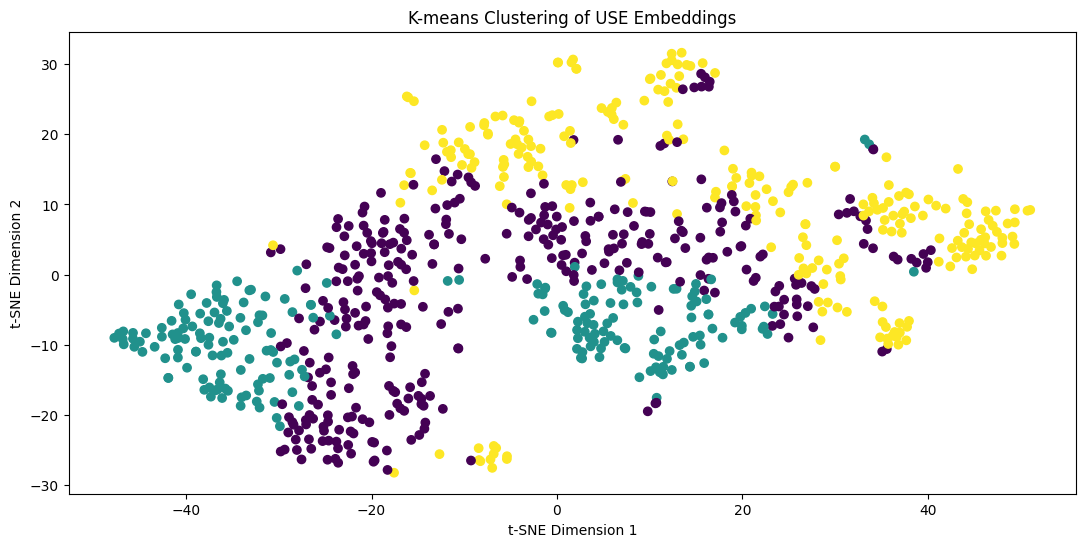

K-Means clustering summary on USE
***********Data points in cluster: 0  :**************
Cardiovascular / Pulmonary    160
Neurology                     114
Gastroenterology               72
Name: category, dtype: int64
***********Data points in cluster: 1  :**************
Cardiovascular / Pulmonary    107
Neurology                      72
Gastroenterology               41
Name: category, dtype: int64
***********Data points in cluster: 2  :**************
Gastroenterology              111
Cardiovascular / Pulmonary    104
Neurology                      37
Name: category, dtype: int64


In [117]:
res_sm = np.array(load_embedding(file_name = "/content/drive/MyDrive/use_embeddings.csv"))
plotKmeansClusteredEmbeddings(res_sm, 'USE')

In [124]:
top = len(medical_terms)

res1 =  embed(medical_terms['Term1'].values)
res2 = embed(medical_terms['Term2'].values)

res = pd.DataFrame({'term1':list(res1['outputs'].numpy()), 'term2': list(res2['outputs'].numpy())}).apply(calculate_similarity, axis=1)
use = res

print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   209.8672585040331
mean cosine_similarity =   0.3761062


### **Using Sentence Encoder With Clinical BERT**

In [120]:
from sentence_transformers import SentenceTransformer
model_name = "emilyalsentzer/Bio_ClinicalBERT"

# Load the SentenceTransformer model
model = SentenceTransformer(model_name)

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/emilyalsentzer_Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Obtain the sentence embeddings
clinic_bert_embeddings = model.encode(data['notes'].values)

In [ ]:
pd.DataFrame(clinic_bert_embeddings).to_csv("/content/drive/MyDrive/clinic_bert_sentence_embeddings.csv")

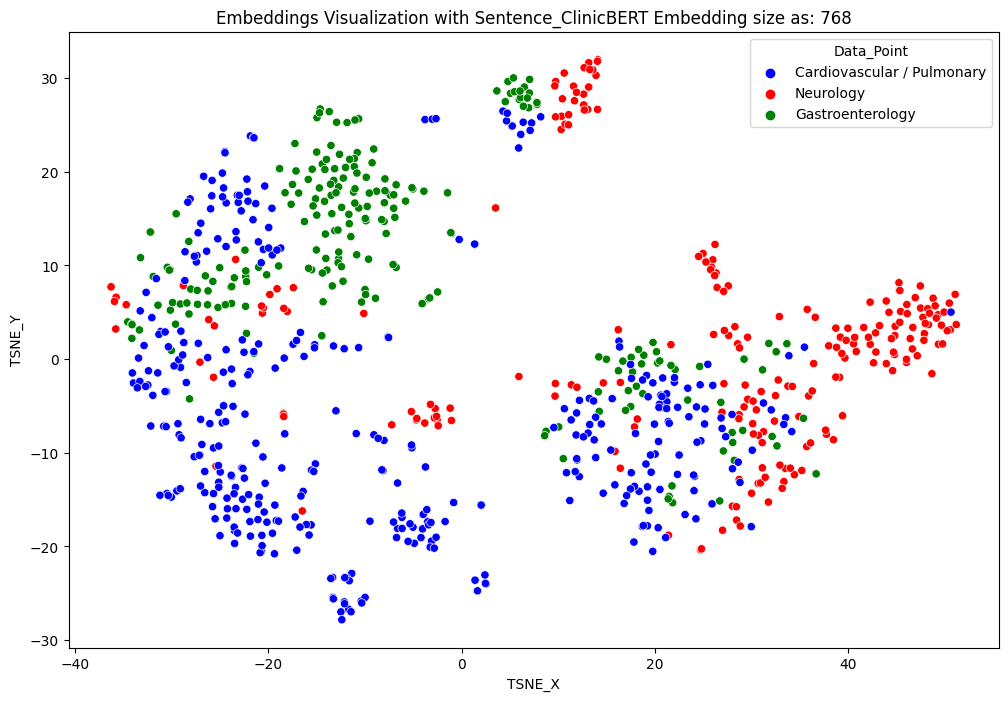

In [109]:
clinic_bert_embeddings2 = np.array(load_embedding(file_name = "/content/drive/MyDrive/clinic_bert_sentence_embeddings.csv"))
plotEmbeddings(list(clinic_bert_embeddings2), data['category'].values, 'Sentence_ClinicBERT')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


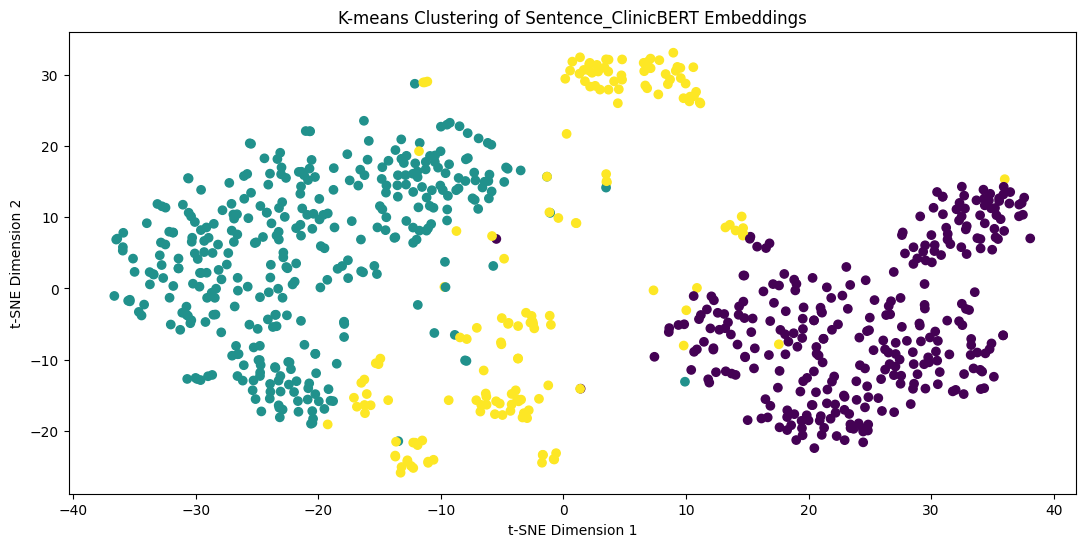

K-Means clustering summary on Sentence_ClinicBERT
***********Data points in cluster: 0  :**************
Neurology                     146
Cardiovascular / Pulmonary    103
Gastroenterology               50
Name: category, dtype: int64
***********Data points in cluster: 1  :**************
Cardiovascular / Pulmonary    182
Gastroenterology              147
Neurology                      26
Name: category, dtype: int64
***********Data points in cluster: 2  :**************
Cardiovascular / Pulmonary    86
Neurology                     51
Gastroenterology              27
Name: category, dtype: int64


In [ ]:
res_sm = np.array(load_embedding(file_name = "/content/drive/MyDrive/clinic_bert_sentence_embeddings.csv"))
plotKmeansClusteredEmbeddings(res_sm, 'Sentence_ClinicBERT')

In [121]:
top = len(medical_terms)
res1 =  model.encode(medical_terms['Term1'].values)
res2 = model.encode(medical_terms['Term2'].values)
res = pd.DataFrame({'term1':list(res1), 'term2': list(res2)}).apply(calculate_similarity, axis=1)
Sentence_ClinicBERT = res

print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   453.9732205271721
mean cosine_similarity =   0.81357205


### **Using Sentence Encoder with BIO BERT**

In [122]:
from sentence_transformers import SentenceTransformer
model_name = "dmis-lab/biobert-v1.1"

# Load the SentenceTransformer model
model = SentenceTransformer(model_name)

In [ ]:

# Obtain the sentence embeddings
Bio_bert_embeddings = model.encode(data['notes'].values)

In [ ]:
pd.DataFrame(Bio_bert_embeddings).to_csv("/content/drive/MyDrive/bio_bert_sentence_embeddings.csv")

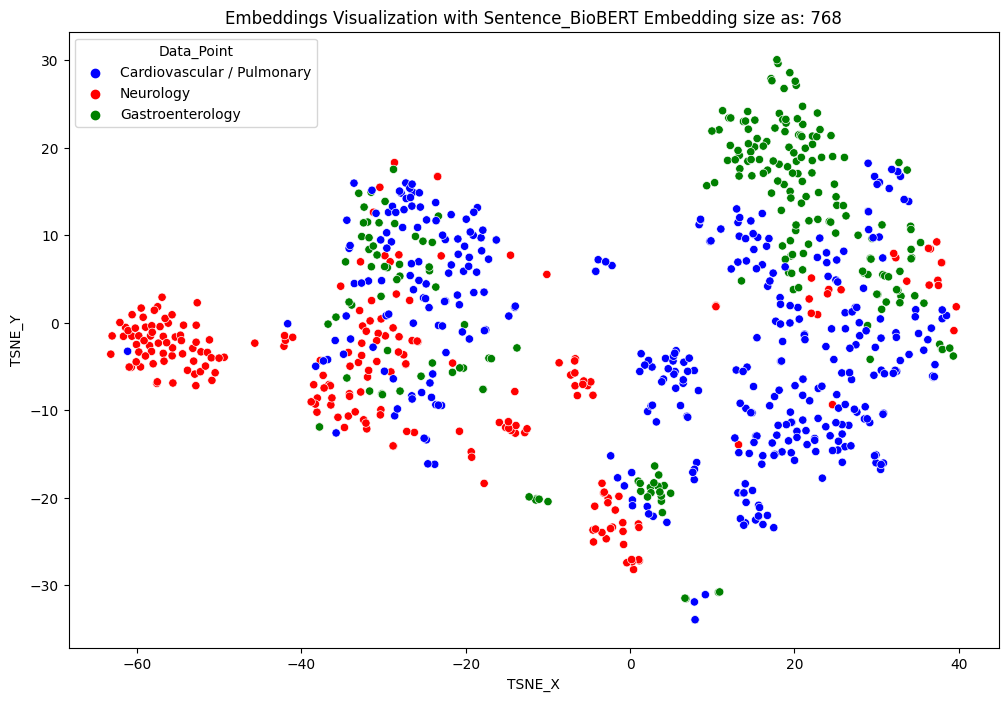

In [ ]:
Bio_bert_embeddings2 = np.array(load_embedding(file_name = "/content/drive/MyDrive/bio_bert_sentence_embeddings.csv"))
plotEmbeddings(list(Bio_bert_embeddings2), data['category'].values, 'Sentence_BioBERT')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


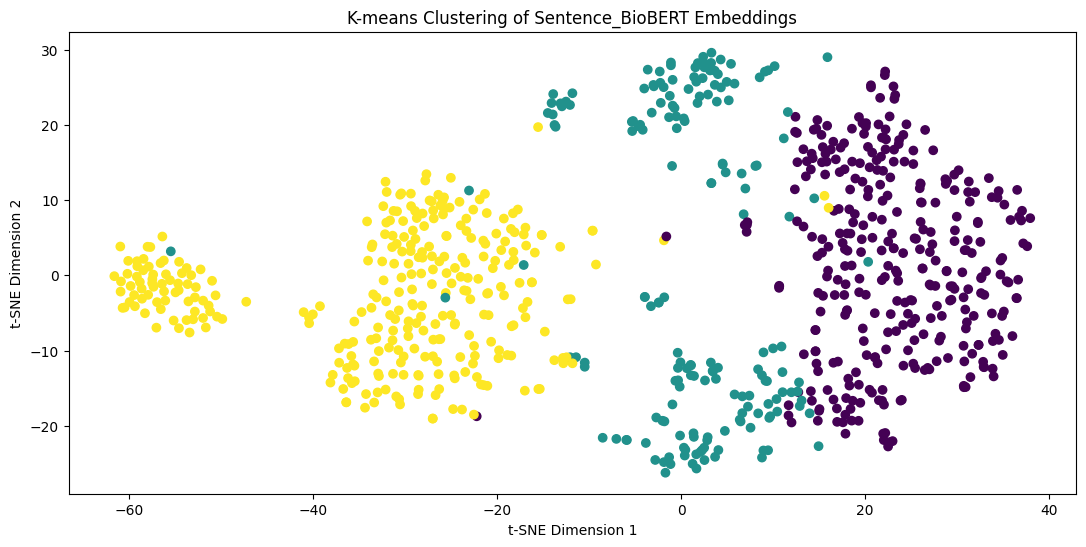

K-Means clustering summary on Sentence_BioBERT
***********Data points in cluster: 0  :**************
Cardiovascular / Pulmonary    156
Gastroenterology              146
Neurology                      25
Name: category, dtype: int64
***********Data points in cluster: 1  :**************
Cardiovascular / Pulmonary    108
Neurology                      46
Gastroenterology               25
Name: category, dtype: int64
***********Data points in cluster: 2  :**************
Neurology                     152
Cardiovascular / Pulmonary    107
Gastroenterology               53
Name: category, dtype: int64


In [ ]:
res_sm = np.array(load_embedding(file_name = "/content/drive/MyDrive/bio_bert_sentence_embeddings.csv"))
plotKmeansClusteredEmbeddings(res_sm, 'Sentence_BioBERT')

In [123]:
top = len(medical_terms)
res1 =  model.encode(medical_terms['Term1'].values)
res2 = model.encode(medical_terms['Term2'].values)
res = pd.DataFrame({'term1':list(res1), 'term2': list(res2)}).apply(calculate_similarity, axis=1)
Sentence_BioBERT = res

print("Total number of pairs =  ", top)
print("Total cosine_similarity =  ", sum(res))
print("mean cosine_similarity =  ", np.mean(res))

Total number of pairs =   558
Total cosine_similarity =   447.63185173273087
mean cosine_similarity =   0.8022076


In [125]:
chars = ['clinical_bert_sentence_transformer', 'bio_bert_sentence_transformer', 'USE']
numbers = [round(np.mean(Sentence_ClinicBERT) * 100, 2), round(np.mean(Sentence_BioBERT) * 100, 2), round(np.mean(use) * 100, 2)]


pd.DataFrame({"chart": chars, "similarity_score" : numbers}).to_csv("/content/drive/MyDrive/sentence_similarity_score.csv")

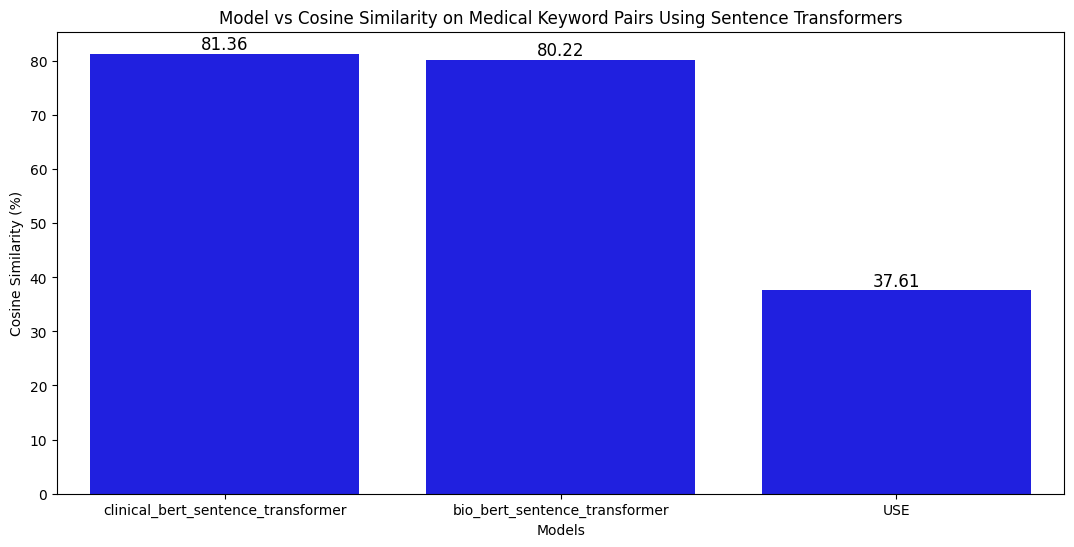

In [126]:
plt.figure(figsize=(13, 6))
ax = sns.barplot(x=chars, y=numbers, color='blue')

# Add annotations to each bar with increased font size
for i, v in enumerate(numbers):
    plt.annotate(str(v), xy=(i, v), ha='center', va='bottom', fontsize=12)

plt.title('Model vs Cosine Similarity on Medical Keyword Pairs Using Sentence Transformers')
plt.xlabel('Models')
plt.ylabel('Cosine Similarity (%)')

plt.show()

## Lests now see the consolidated perfomence of all models on keyword **similarity** task

In [127]:
file_path = '/content/drive/MyDrive/all_model_similarity.csv'
all_model_similarity = pd.read_csv(file_path)
all_model_similarity.drop('Unnamed: 0', inplace=True, axis=1)
all_model_similarity

,chart,similarity_score
0,word2vec_small,43.00
1,word2vec_large,22.94
2,ELMO,55.23
3,bio_bert,80.22
4,clinical_bert,81.36
5,blue_bert,72.49
6,clinic_notes_based_finetuned_bert,77.73
7,keyword_based_finetuned_bert,81.74
8,keyword_and_clinic_notes_based_finetuned_bert1,78.18


In [129]:
all_model_similarity = pd.concat([all_model_similarity,pd.DataFrame({"chart": chars, "similarity_score" : numbers})])

In [130]:
all_model_similarity.reset_index(drop=True, inplace=True)
all_model_similarity

,chart,similarity_score
0,word2vec_small,43.00
1,word2vec_large,22.94
2,ELMO,55.23
3,bio_bert,80.22
4,clinical_bert,81.36
5,blue_bert,72.49
6,clinic_notes_based_finetuned_bert,77.73
7,keyword_based_finetuned_bert,81.74
8,keyword_and_clinic_notes_based_finetuned_bert1,78.18
9,clinical_bert_sentence_transformer,81.36


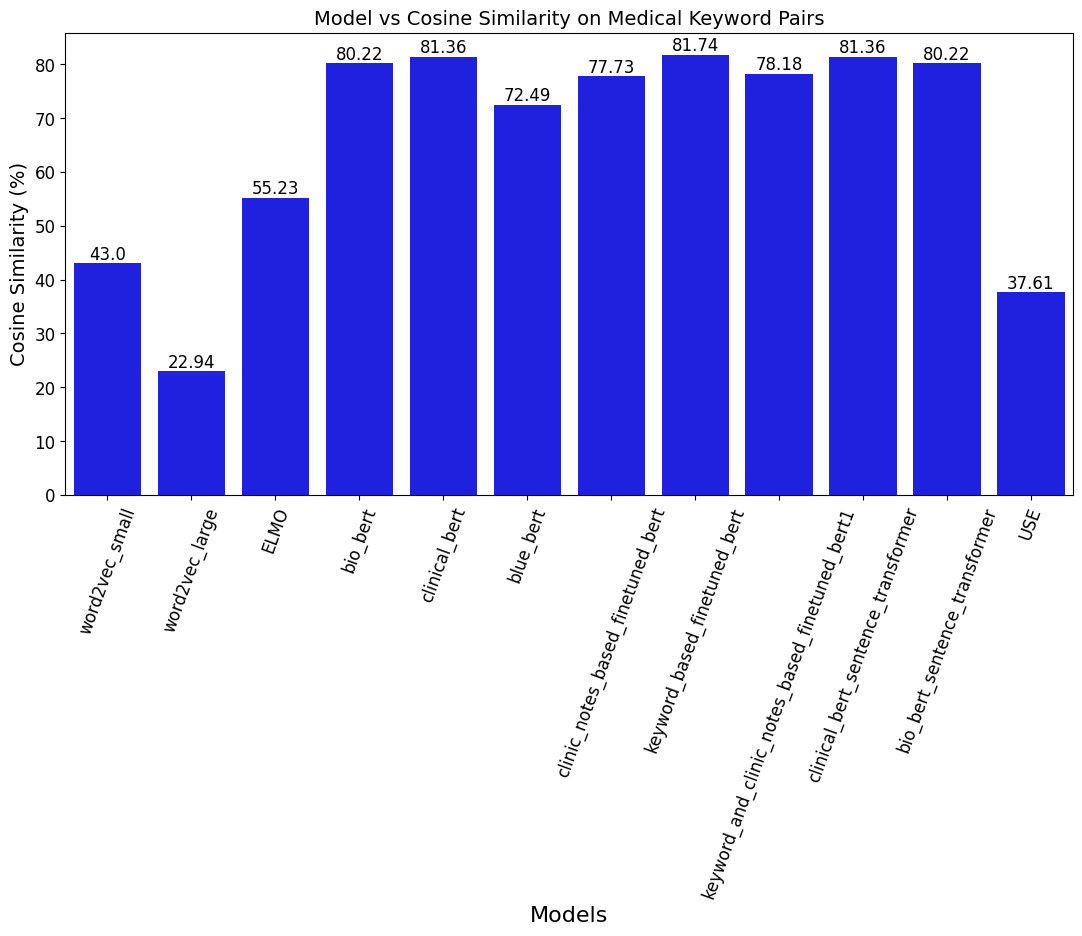

In [131]:
plt.figure(figsize=(13, 6))
ax = sns.barplot(x=all_model_similarity['chart'], y=all_model_similarity['similarity_score'], color='blue')

# Add annotations to each bar with increased font size
for i, v in enumerate(all_model_similarity['similarity_score'].values):
    plt.annotate(str(v), xy=(i, v), ha='center', va='bottom', fontsize=12)


plt.title('Model vs Cosine Similarity on Medical Keyword Pairs', fontsize=14)
plt.xlabel('Models', fontsize=16)
plt.ylabel('Cosine Similarity (%)', fontsize=14)


plt.xticks(rotation=70, fontsize=12)
plt.yticks(fontsize=12)

plt.show()